* Here is an implementation of paper [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) on Brain Tumor dataset.
* SRGAN uses the GAN to produce the high resolution images from the low resolution images. In this implementation, for training, the original 512 X 512 high resolution image is downsampled into low resolution image using Gaussian blur followed by resizing it to 128 X 128. A Generator is used to generate 512 X 512 images from 128 X 128 images and a discriminator is used to distinguish the generated images from the HR images.

### Let's create an output directory to store the images generated by the generator and also save the model after certain number of epochs

In [1]:
import os
os.mkdir('./output')

### Here I am defining my GAN network architecture

## GAN Network Architecture (Network.py)

### The model is assembled from two components Discriminator and Generator. Discriminator - Responsible to distinguish between generated photos and real photos. Generator - Generate high resolution images from low resolution images.

![Network Image](https://github.com/mayank1101/Master-Thesis-Work/blob/main/Implementation%20Work/SRGAN/img/network.jpg?raw=true)

* Above is the architecture of generator and discriminator used in the reference paper. k9n64s1 signifies kernel of size 9, 64 channels and stride of 1. Residual blocks are used in the discriminator. Two new concepts which are used in the network architecture are **PRelu** and **PixelShuffler**.
* **PRelu:** is a kind of leakyRelu where instead of a predefined slope of 0.01, it makes it parameter for the neural network to itself decide the value of slope. y=ax when x<0 and y=x when x> 0 where a is the parameter to be determined by the network.
* **PixelShuffling:** rearrange the tensor of shape (N,C,H,W) into (N,C/r*r,H*r,W*r) where r is the shuffling factor. It basically convert the depth(channel) into the space(height and width). In Generator, pixelshuffling is used to upsample the images size.

In [2]:
# Importing all the necessary modules

from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import add

In [3]:
# Residual block
def res_block_gen(model, kernal_size, filters, strides):
    
    gen = model
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
        
    model = add([gen, model])
    
    return model

In [4]:
def up_sampling_block(model, kernal_size, filters, strides):
    '''
    In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    Even we can have our own function for deconvolution
    model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    '''
    
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

In [5]:
def discriminator_block(model, filters, kernel_size, strides):
    
    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)
    
    return model

## Generator

* 7 Convolution blocks Each block with the same number of filters
* PReLU with ( α = 0.2 ) is used as activation layer
* 2 PixelShuffler layers for upsampling - PixelShuffler is feature map upscaling
* Skip connections are used to achieve faster convergence

In [6]:
# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Generator(object):

    def __init__(self, noise_shape):
        
        self.noise_shape = noise_shape

    def generator(self):
        
        gen_input = Input(shape = self.noise_shape)

        model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
        model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)

        gen_model = model

        # Using 16 Residual Blocks
        for index in range(16):
            model = res_block_gen(model, 3, 64, 1)

        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
        model = BatchNormalization(momentum = 0.5)(model)
        model = add([gen_model, model])

        # Using 2 UpSampling Blocks
        for index in range(2):
            model = up_sampling_block(model, 3, 256, 1)

        model = Conv2D(filters = 1, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('tanh')(model)

        generator_model = Model(inputs = gen_input, outputs = model)

        return generator_model

## Discriminator

* 16 Residual blocks Each block with increasing number of filters
* LeakyReLU with ( α = 0.2 ) is used as activation layer
* 2 Dense layers


In [7]:
# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Discriminator(object):

    def __init__(self, image_shape):
        
        self.image_shape = image_shape
    
    def discriminator(self):
        
        dis_input = Input(shape = self.image_shape)
        
        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)
        
        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)
        
        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)
       
        model = Dense(1)(model)
        model = Activation('sigmoid')(model) 
        
        discriminator_model = Model(inputs = dis_input, outputs = model)
        return discriminator_model

In [8]:
def get_gan_network(discriminator, shape, generator, optimizer):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=["binary_crossentropy", "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

## Extract the images from .mat file and preprocess them for training.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications.vgg19 import VGG19
from keras.layers.convolutional import UpSampling2D
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
import keras
import keras.backend as K
from keras.layers import Lambda, Input
import tensorflow as tf
import skimage.transform
from skimage import data, io, filters
import numpy as np
from numpy import array
from skimage.transform import rescale, resize
from skimage.transform import resize
import os


from matplotlib.pyplot import imread
import h5py
import cv2

np.random.seed(10)
image_shape = (512,512,1)

### Here we have defined three custom functions load_path and load_data_from_dir and load_data which are used to read in the images from input directory. 

In [10]:
def load_path(path):
    directories = []
    if os.path.isdir(path):
        directories.append(path)
    for elem in os.listdir(path): #check for nested dir within parent dir
        if os.path.isdir(os.path.join(path,elem)):
            directories = directories + load_path(os.path.join(path,elem))
            directories.append(os.path.join(path,elem))
    return directories

In [11]:
def load_data_from_dirs(dirs, ext):
    files = []
    file_names = []
    for d in dirs:
        for f in os.listdir(d):
            if f.endswith(ext):
                image = h5py.File(os.path.join(d,f), 'r')
                files.append(image)
                file_names.append(os.path.join(d,f))
    return files   

In [12]:
def load_data(directory, ext):

    files = load_data_from_dirs(load_path(directory), ext)
    return files

In [13]:
files = load_data("../input/braintumor/BrainTumorData/", ".mat")
x_train_h5 = files[:500]
x_test_h5 = files[600:900]

## Now after reading the images, let's analyze them.

In [14]:
print('Total files: ',len(files),' x_train: ', len(x_train_h5),' x_test', len(x_test_h5))

Total files:  3064  x_train:  500  x_test 300


In [15]:
print(x_train_h5[0], x_train_h5[1])

<HDF5 file "2912.mat" (mode r)> <HDF5 file "2011.mat" (mode r)>


In [16]:
print(x_train_h5[0].keys())
print(x_train_h5[0]['cjdata'])
print(x_train_h5[0]['cjdata']['PID'])
print(x_train_h5[0]['cjdata']['image'])
print(x_train_h5[0]['cjdata']['label'])
print(x_train_h5[0]['cjdata']['tumorBorder'])
print(x_train_h5[0]['cjdata']['tumorMask'])

<KeysViewHDF5 ['cjdata']>
<HDF5 group "/cjdata" (5 members)>
<HDF5 dataset "PID": shape (9, 1), type "<u2">
<HDF5 dataset "image": shape (512, 512), type "<i2">
<HDF5 dataset "label": shape (1, 1), type "<f8">
<HDF5 dataset "tumorBorder": shape (1, 30), type "<f8">
<HDF5 dataset "tumorMask": shape (512, 512), type "|u1">


## Attributes and their meaning
### Here we can clearly see that image has following attributes:
* cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
* cjdata.PID: patient ID
* cjdata.image: image data
* cjdata.tumorBorder: a vector storing the coordinates of discrete points on the tumour border. For example, [x1, y1, x2, y2,…] in which x1, y1 are planar coordinates on tumour border. It was generated by manually delineating the tumour border. So we can use it to generate binary image of tumour mask.
* cjdata.tumorMask: a binary image with 1s indicating tumour region

In [17]:
## cjdata.PID: patient ID

print('Patient ID: ', files[0]['cjdata']['PID'][()])

Patient ID:  [[77]
 [82]
 [48]
 [53]
 [48]
 [55]
 [57]
 [49]
 [66]]


In [18]:
## cjdata.image: image data

print('Tumour Image Array: ', files[0]['cjdata']['image'][()])

Tumour Image Array:  [[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 3  3 14 ... 14 13 13]
 [ 3  3 12 ... 12 11 11]
 [ 2  2 11 ...  8 10 10]]


### Let's visualize the image.

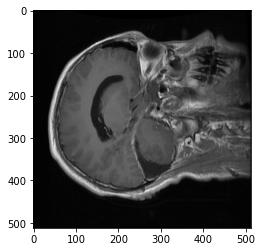

In [19]:
plt.imshow(files[0]['cjdata']['image'][()].squeeze(), cmap='gray')

In [20]:
## cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor

print('label: ', files[0]['cjdata']['label'][()])

label:  [[2.]]


In [21]:
## cjdata.tumorBorder: a vector storing the coordinates of discrete points on the tumour border. 
## For example, [x1, y1, x2, y2,…] in which x1, y1 are planar coordinates on tumour border. 
## It was generated by manually delineating the tumour border. So we can use it to generate binary image of tumour mask.

print('Tumour Border: ', files[0]['cjdata']['tumorBorder'][()])

Tumour Border:  [[294.3554007  240.83623693 322.00696864 239.94425087 349.65853659
  247.08013937 382.66202091 258.67595819 394.25783972 265.81184669
  396.04181185 276.51567944 393.36585366 291.67944251 379.98606272
  313.08710801 366.60627178 322.8989547  361.2543554  322.8989547
  360.36236934 302.38327526 355.01045296 278.29965157 349.65853659
  264.02787456 325.57491289 249.75609756 305.05923345 246.18815331]]


In [22]:
## cjdata.tumorMask: a binary image with 1s indicating tumour region

print('Tumour Mask: ',files[0]['cjdata']['tumorMask'][()])

Tumour Mask:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Let's visualize the tumor mask

(-0.5, 511.5, 511.5, -0.5)

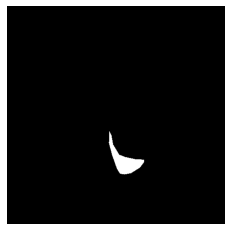

In [23]:
plt.imshow(files[0]['cjdata']['tumorMask'][()].squeeze(), cmap='gray')
plt.axis('off')

### Now we will do some preprocessing on the input images.
* We will convert 512x512 to 512x512x1 to make it comaptible to model input.
* Downsample each image by factor of 4.
* Normalize all pixels between 0 and 1.

In [24]:
x_train = [np.expand_dims(array(mat['cjdata']['image'][()]), axis=2) for mat in x_train_h5]
x_test = [np.expand_dims(array(mat['cjdata']['image'][()]), axis=2) for mat in x_test_h5]

In [25]:
print(len(x_train),x_train[0].shape, type(x_test[0]))

500 (512, 512, 1) <class 'numpy.ndarray'>


### So, we can clearly see that we have 500 images each of size (512 X 512 X 1) and each image is a numpy array.

### Here we have defined few utility functions to achive our task of preprocessing the images.
* hr_images convert image to numpy array.
* lr_images downsample each image by factor of 4.
* preprocess_HR scale pixel values between 0 and 1.
* deprocess_HR scale up pixel values from 0-1 to 0-255.
* preprocess_LR scale lower resolution image pixel values between 0 and 1.
* deprocess_LRS clip the pixel values between 0-255. 

In [26]:
def hr_images(images):
    images_hr = array(images)
    return images_hr


def lr_images(images_real , downscale):
    
    images = []
    for img in  range(len(images_real)):
        im = cv2.resize(images_real[img], 
                                 (images_real[img].shape[0]//downscale,images_real[img].shape[1]//downscale),
                                 interpolation=cv2.INTER_CUBIC)
        images.append(np.expand_dims(im,axis=2))
    images_lr = array(images)
    return images_lr


def preprocess_HR(x):
    return np.divide(x.astype(np.float32), 127.5) - np.ones_like(x,dtype=np.float32)


def deprocess_HR(x):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8) 

def preprocess_LR(x):
    return np.divide(x.astype(np.float32), 255.)

def deprocess_LR(x):
    x = np.clip(x*255, 0, 255)
    return x

def normalize(input_data):
    input_data_normalize = [(img.astype(np.float32) - 127.5)/127.5 for img in input_data]
    return array(input_data_normalize)

def denormalize(input_data):
    input_data = array([(img.astype(np.float32) + 1).astype(np.uint8) * 127.5 for img in input_data])
    return input_data

def deprocess_LRS(x):
    x = np.clip(x*255, 0, 255)
    return x.astype(np.uint8)

### Preprocess train dataset.

In [27]:
x_train_hr = hr_images(x_train)
x_train_hr = normalize(x_train_hr)
x_train_lr = lr_images(x_train, 4)
x_train_lr = normalize(x_train_lr)

### Preprocess test dataset.

In [28]:
x_test_hr = hr_images(x_test)
x_test_hr = normalize(x_test_hr)
x_test_lr = lr_images(x_test, 4)
x_test_lr = normalize(x_test_lr)

### Now we will remove unwanted images form train set, beacuse we want to make sure that we have all the images of desired size 512x512.

### Preprocess train set images

In [29]:
for idx, img in enumerate(x_train_hr):
    if img.shape != (512,512,1):
        print(idx+1,' Image: ',img.shape)

155  Image:  (256, 256, 1)
480  Image:  (256, 256, 1)


### Here we can clearly see that we have two images of size (256,256,1) at indexes 155 and 480 which we don't want in training. Therefore we need to remove these images.

In [30]:
for idx, img in enumerate(x_train_lr):
    if img.shape != (128,128,1):
        print(idx+1,' Image: ',img.shape)

155  Image:  (64, 64, 1)
480  Image:  (64, 64, 1)


### Here we can clearly see that we have two images of size (64,64,1) at indexes 155 and 480 which we don't want in training. Therefore we need to remove these images.

In [31]:
x_train_lr_new = []
for idx, img in enumerate(x_train_lr):
    if img.shape == (128,128,1):
        x_train_lr_new.append(img)
x_train_lr_new = array(x_train_lr_new)

In [32]:
x_train_lr_new.shape

(498, 128, 128, 1)

### After removing those unwanted images now we have 498 total images.

In [33]:
x_train_hr_new = []
for i in range(len(x_train_hr)):
    if x_train_hr[i].shape == (512,512,1):
        x_train_hr_new.append(x_train_hr[i])
x_train_hr_new = array(x_train_hr_new)

In [34]:
x_train_hr_new.shape

(498, 512, 512, 1)

### After removing those unwanted images now we have 498 total images.

### Preprocess test images

In [35]:
print(x_test_hr.shape, x_test_hr[0].shape)

(300,) (512, 512, 1)


### We have total of 300 images in test set

In [36]:
x_test_hr_new = []
for i in range(len(x_test_hr)):
    if x_test_hr[i].shape == (512,512,1):
        x_test_hr_new.append(x_test_hr[i])
x_test_hr_new = array(x_test_hr_new)

In [37]:
x_test_hr_new.shape

(297, 512, 512, 1)

In [38]:
print(x_test_lr.shape, x_test_lr[0].shape)

(300,) (128, 128, 1)


In [39]:
x_test_lr_new = []
for i in range(len(x_test_lr)):
    if x_test_lr[i].shape == (128,128,1):
        x_test_lr_new.append(x_test_lr[i])
x_test_lr_new = array(x_test_lr_new)

In [40]:
x_test_lr_new.shape

(297, 128, 128, 1)

### After removing unwanted images from test set, now we have 287 images to test, all of same size.

## Now we will visualize few images from test set and see how they look after all the preprocessing work we did.

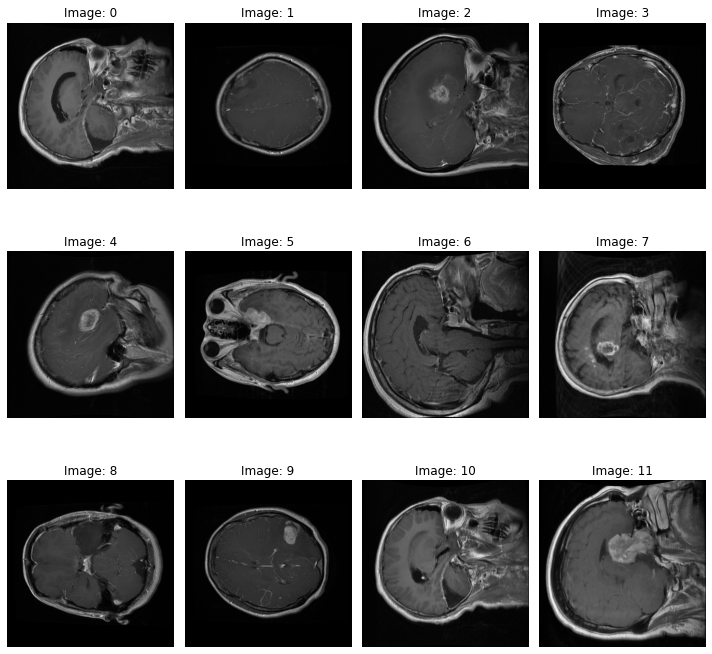

In [41]:
%matplotlib inline


width=8
height=8
rows = 3
cols = 4
axes=[]

fig=plt.figure(figsize=(10,10))

for i in range(rows * cols):
    axes.append( fig.add_subplot(rows, cols, i+1) )
    subplot_title=("Image: "+str(i))
    axes[-1].set_title(subplot_title)  
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.axis('off')
fig.tight_layout()    
plt.show()

## Evaluation metrics
* PSNR
* Mean Squared Error
* SSIM (Structure Similarity Index)
* **Now we will define function compare_images which is used to evalute quality of generated results.**

In [42]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

In [43]:
def compare_images(original, generated):
    '''
    Input:
        original : Original HR Image
        generated : Image Generated by GAN
    return:
        returns psnr and ssim metrics
    '''
    scores = []
    scores.append(cv2.PSNR(original, generated))
    scores.append(ssim(original, generated, multichannel=True))
    scores.append(mse(original, generated))
    
    return scores

### Here we have defined a function plot_generated_images. What this function does is, after every 20 epochs, it evalute the generated images and compute metrics for each. 

In [44]:
def plot_generated_images(epoch,generator, examples=3 , dim=(1, 3), figsize=(15, 5)):
    
    rand_nums = np.random.randint(0, x_test_hr_new.shape[0], size=examples)
    #print('rand_nums: ',rand_nums,' x_test_hr.shape[0]: ', x_test_hr.shape[0])
    image_batch_hr = denormalize(x_test_hr_new[rand_nums])
    image_batch_lr = np.stack(x_test_lr_new[rand_nums], axis=0)
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)
    
    #generated_image = deprocess_HR(generator.predict(image_batch_lr))
    if epoch % 20 == 0:
        plt.figure(figsize=figsize)

        plt.subplot(dim[0], dim[1], 1)
        plt.imshow(image_batch_lr[1].squeeze(), interpolation='nearest')
        plt.title('Down Sampled Image after eopch {}'.format(epoch))
        plt.axis('off')

        plt.subplot(dim[0], dim[1], 2)
        plt.imshow(generated_image[1].squeeze(), interpolation='nearest')
        plt.title('Image Generated by Generator of GAN eopch {}'.format(epoch))
        plt.axis('off')

        plt.subplot(dim[0], dim[1], 3)
        plt.imshow(image_batch_hr[1].squeeze(), interpolation='nearest')
        plt.title('Original HR Image eopch {}'.format(epoch))
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('./output/gan_generated_image_epoch_%d.png' % epoch)
    
    ## Printing PSNR AND SSIM
    metric_score = compare_images(image_batch_hr[1], generated_image[1])
    PSNR, SSIM, PMSE = metric_score[0], metric_score[1], metric_score[2]
    print('PSNR for Generated Image:', PSNR)
    print('SSIM for Generated Image:', SSIM)
    print('MSE for Generated Image:', PMSE)
    return (PSNR, SSIM, PMSE)

## Now we will do the training

### Here we define batch size and number of epochs to train our network.

In [45]:
epochs=220 # epochs = 20000
batch_size=4

### Now we create our generator and discriminator objects and initialize our network

In [46]:
downscale_factor = 4
    
batch_count = int(x_train_hr_new.shape[0] / batch_size)
shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])
generator = Generator(shape).generator()
discriminator = Discriminator(image_shape).discriminator()

adam = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
generator.compile(loss="binary_crossentropy", optimizer=adam)
discriminator.compile(loss="binary_crossentropy", optimizer=adam)

shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, 1)
gan = get_gan_network(discriminator, shape, generator, adam)

### Here we do our training
* Here, the LR images are passed into the generator to generate high resolution images and then pass these generated images as well as the original HR images to discriminator to get the fake label and real label respectively. Then, discriminator is trained that the generated images are fake images while the original HR images are real images by giving them labels as zeros and ones respectively.


![Training Image](https://github.com/mayank1101/Master-Thesis-Work/blob/main/Implementation%20Work/SRGAN/img/architecture.jpg?raw=true)

--------------- Epoch 1 ---------------
Loss HR , Loss LR, Loss GAN
1.717254638671875 2.108952760696411 [-45.777793884277344, -45.77947998046875, 1.686173677444458]
PSNR for Generated Image: -5.540165048407596
SSIM for Generated Image: 0.2718576651547905
MSE for Generated Image: 232861.05766296387
--------------- Epoch 2 ---------------
Loss HR , Loss LR, Loss GAN
2.472028970718384 1.3411210775375366 [-35.28767013549805, -35.28898239135742, 1.3113287687301636]
PSNR for Generated Image: -10.475886952776513
SSIM for Generated Image: 0.5115097688911904
MSE for Generated Image: 725552.8563022614
--------------- Epoch 3 ---------------
Loss HR , Loss LR, Loss GAN
1.7492882013320923 2.5602316856384277 [-11.50678539276123, -11.507369995117188, 0.5845702290534973]
PSNR for Generated Image: 10.120338051658592
SSIM for Generated Image: 0.5757193586811123
MSE for Generated Image: 6324.796485900879
--------------- Epoch 4 ---------------
Loss HR , Loss LR, Loss GAN
2.5878729820251465 2.46688699722

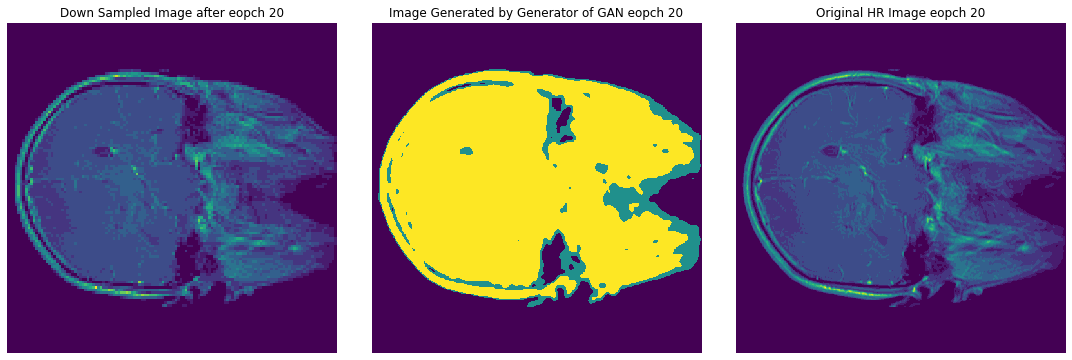

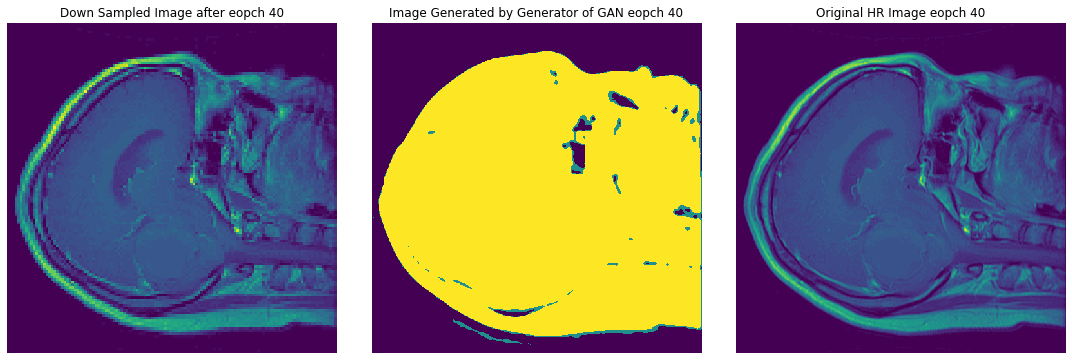

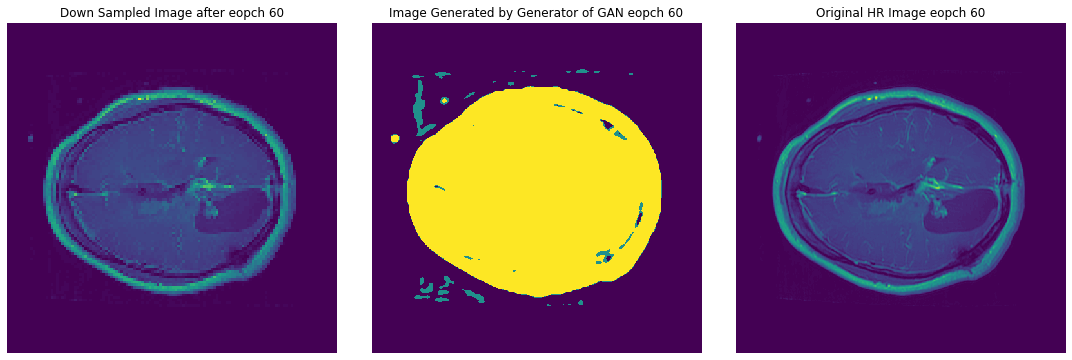

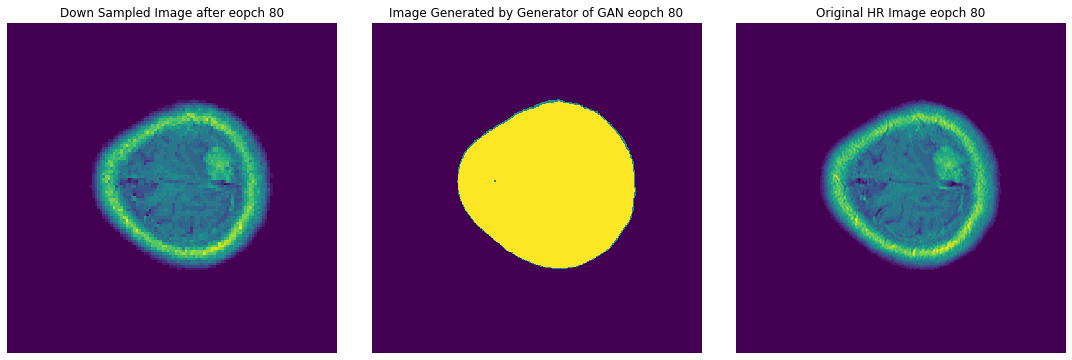

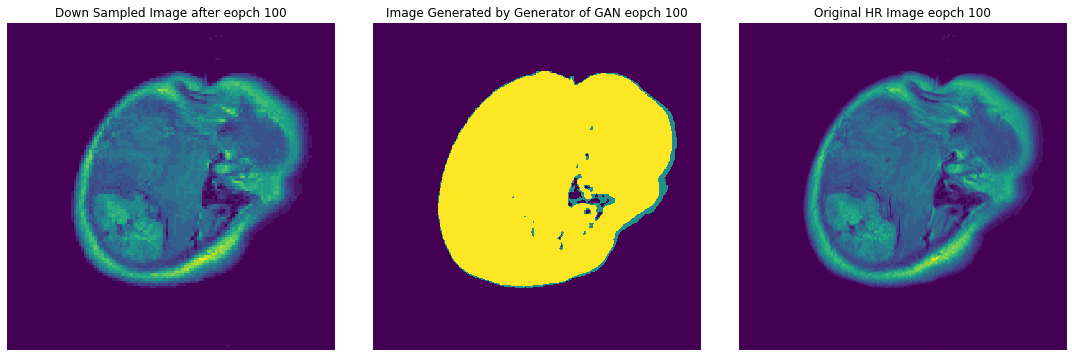

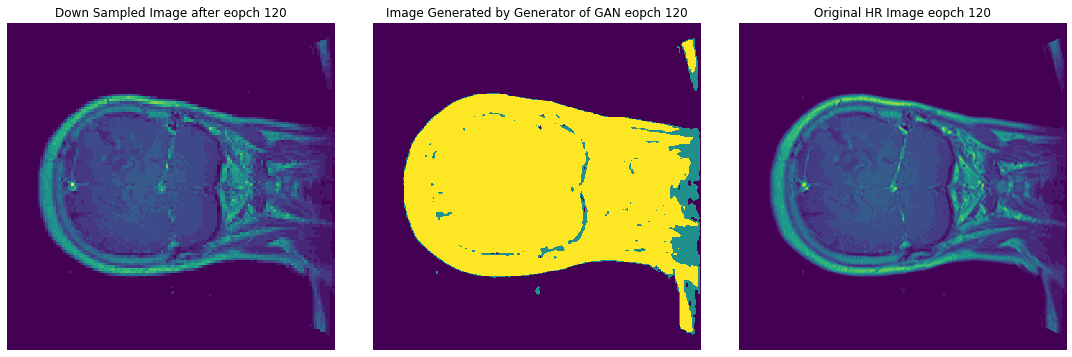

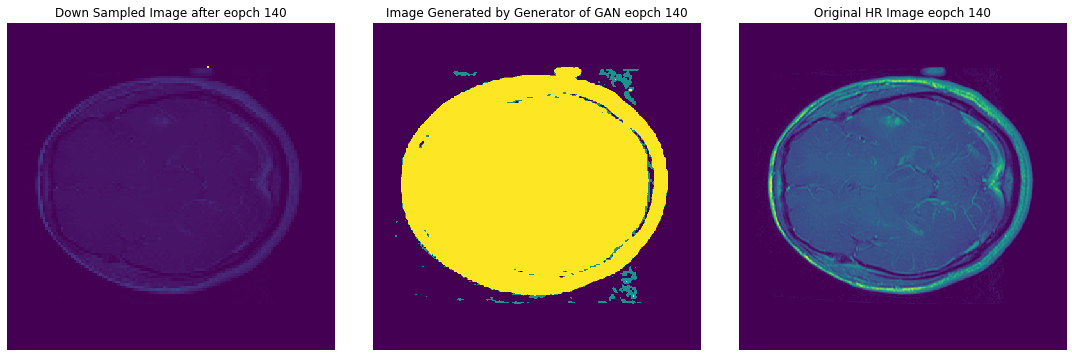

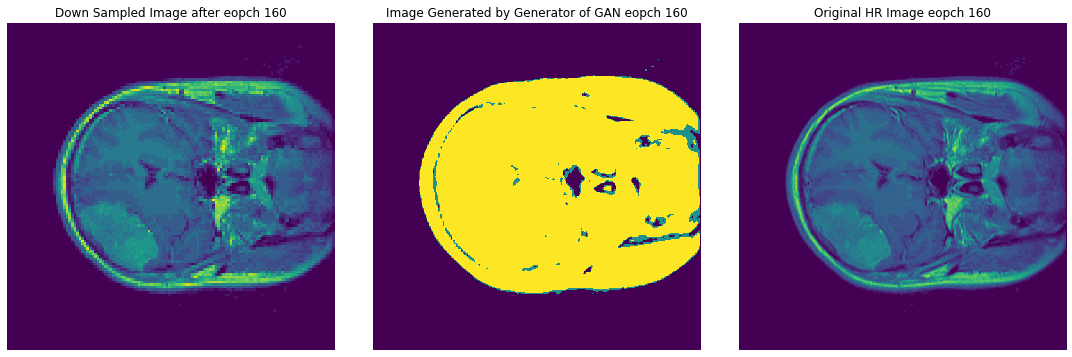

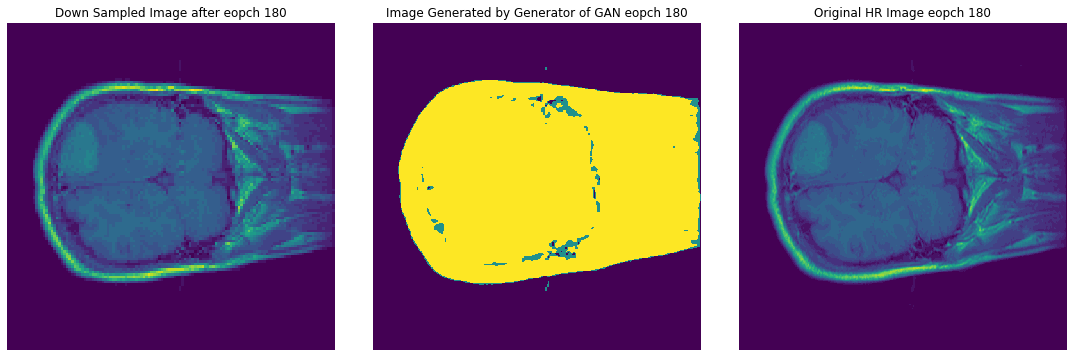

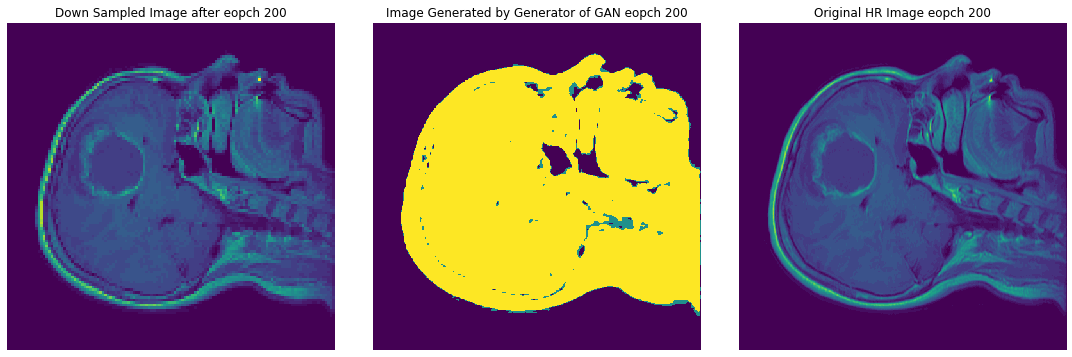

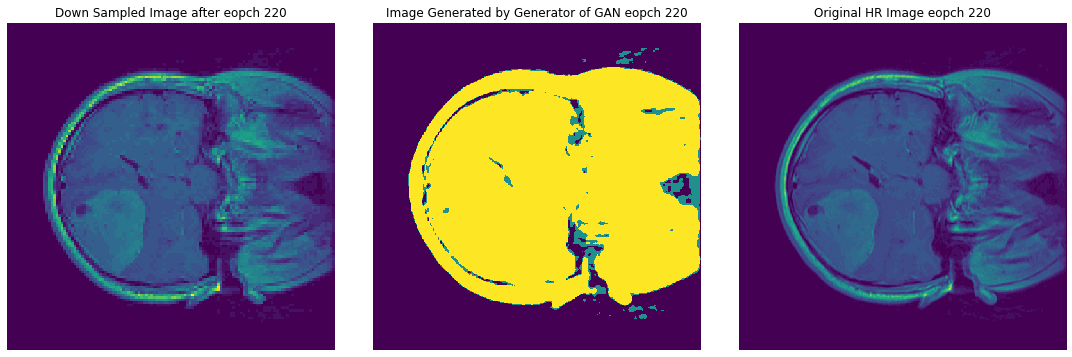

In [47]:
hr_loss, lr_loss, gan_loss = [], [], []
m1, m2, m3 = [], [], []

for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    for i in range(batch_count):
        rand_nums = np.random.randint(0, x_train_hr_new.shape[0], size=batch_size)

        image_batch_hr =  np.stack(x_train_hr_new[rand_nums], axis=0)
        image_batch_lr = np.stack(x_train_lr_new[rand_nums], axis=0)
            
        generated_images_sr = generator.predict(image_batch_lr)

        real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
        fake_data_Y = np.random.random_sample(batch_size)*0.2

        discriminator.trainable = True

        d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
        d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
        #d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

        rand_nums = np.random.randint(0, x_train_hr_new.shape[0], size=batch_size)
    
        image_batch_hr =  np.stack(x_train_hr_new[rand_nums], axis=0)
        image_batch_lr = np.stack(x_train_lr_new[rand_nums], axis=0)

        gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2

        discriminator.trainable = False
        loss_gan = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])

    print("Loss HR , Loss LR, Loss GAN")
    print(d_loss_real, d_loss_fake, loss_gan)
    hr_loss.append(d_loss_real)
    lr_loss.append(d_loss_fake)
    gan_loss.append(loss_gan)
    
    PSNR, SSIM, PMSE = plot_generated_images(e, generator)
    m1.append(PSNR)
    m2.append(SSIM)
    m3.append(PMSE)
#     plot_generated_images(e, generator)
    
    if e % 220 == 0:
        generator.save('./output/gen_model%d.h5' % e)
        discriminator.save('./output/dis_model%d.h5' % e)
        gan.save('./output/gan_model%d.h5' % e)

### Here we visualize our HR Image Loss, LR Image Loss and GAN Loss for each epoch
### Let's understand what each loss means
* **Loss Function:** Here we are using Perceptual loss. It comprises of Content(Reconstruction) loss and Adversarial loss.
* **HR Loss** (Adversarial Loss) which is a binary_crossentropy
* **LR Loss** (ContentLoss) which is a binary_crossentropy
* **GAN Loss** (Perceptual Loss) Generator loss is actually sum of **Content Loss** and **Adversarial Loss**.

## Now we will analyze our loss and evaluation metrics

In [48]:
plt.style.use('ggplot')

### Visualizing 
* (GAN Loss) Perceptual Loss
* (HR Loss) Adversarial Loss
* (LR Loss) Content(Reconstruction) loss

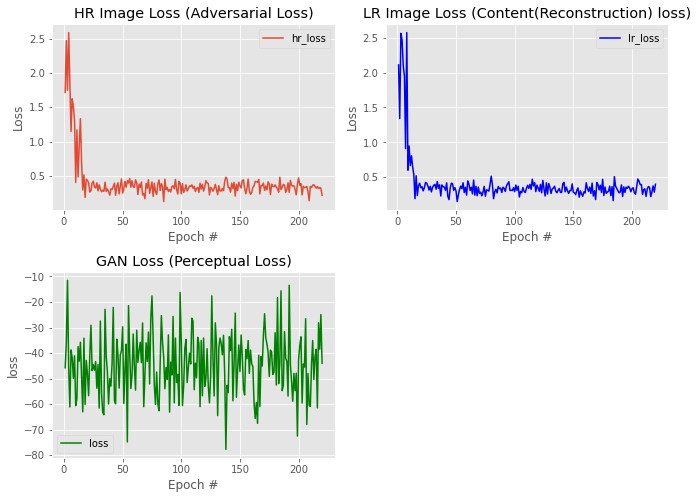

In [49]:
epochs = np.arange(1,len(hr_loss)+1)

fig = plt.figure(figsize=(10,10))
plt.subplot(3, 2, 1)

## Plotting HR Loss

plt.plot(epochs, hr_loss, label='hr_loss')
plt.title('HR Image Loss (Adversarial Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend()

## Plotting LR Loss

plt.subplot(3,2,2)
plt.plot(epochs, lr_loss, label='lr_loss', color='b')
plt.title('LR Image Loss (Content(Reconstruction) loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend() 

## Plotting GAN Loss

loss, fun_1_loss, fun_3_loss = [], [], []

for l1, l2, l3 in gan_loss:
    loss.append(l1)
    fun_1_loss.append(l2)
    fun_3_loss.append(l3)

plt.subplot(3,2,3)
plt.plot(epochs, loss, label='loss', color='g')
plt.title('GAN Loss (Perceptual Loss)')
plt.ylabel('loss')
plt.xlabel('Epoch #')
plt.legend() 

# plt.subplot(3,2,4)
# plt.plot(epochs, fun_1_loss, label='fun_1_loss', color='y')
# plt.title('GAN Loss')
# plt.ylabel('functional_1_loss')
# plt.xlabel('Epoch #')
# plt.legend() 


# plt.subplot(3,2,5)
# plt.plot(epochs, fun_3_loss, label='fun_3_loss', color='k')
# plt.title('GAN Loss')
# plt.ylabel('functional_3_loss')
# plt.xlabel('Epoch #')
# plt.legend() 

fig.tight_layout()

### Visualize PSNR for each epoch

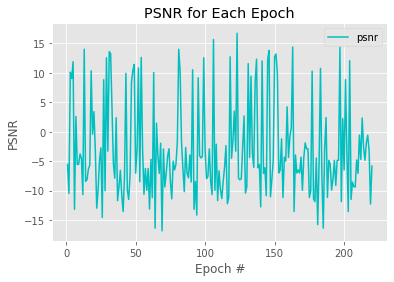

In [50]:
plt.plot(epochs, m1, label='psnr', color='c')
plt.title('PSNR for Each Epoch')
plt.ylabel('PSNR')
plt.xlabel('Epoch #')
plt.legend() 

### Visualize SSIM for each epoch

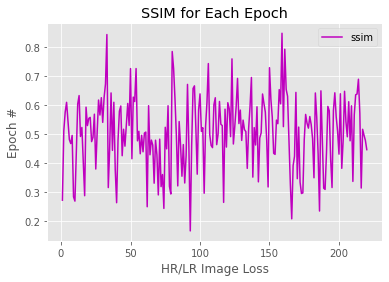

In [51]:
plt.plot(epochs, m2, label='ssim', color='m')
plt.title('SSIM for Each Epoch')
plt.xlabel('HR/LR Image Loss')
plt.ylabel('Epoch #')
plt.legend() 

### Visualize MSE for each epoch

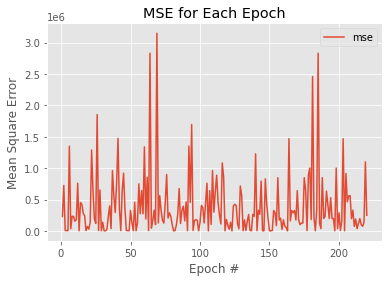

In [52]:
plt.plot(epochs, m3, label='mse')
plt.title('MSE for Each Epoch')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch #')
plt.legend() 

In [53]:
print('Avg. PSNR and Std for Generated Images:', np.mean(np.array(m1)), np.std(np.array(m1)))
print('Avg. SSIM and Std for Generated Images:', np.mean(np.array(m2)), np.std(np.array(m2)))
print('Avg. MSE and Std for Generated Images:', np.mean(np.array(m3)), np.std(np.array(m3)))

Avg. PSNR and Std for Generated Images: -3.2142207011183617 8.06920084913721
Avg. SSIM and Std for Generated Images: 0.5053453908957586 0.12482326044687929
Avg. MSE and Std for Generated Images: 382011.11467383127 494227.1688465232


### zip the final model

In [54]:
%%!

zip final_model.zip ./output

['  adding: output/ (stored 0%)']